In [10]:
import os
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
 
parent_folder = "./ml_exercise_therapanacea"

# original image folder and data labels documents
original_folder = os.path.join(parent_folder, "train_img")
labels_file = os.path.join(parent_folder, "label_train.txt")

# Read labels into a list
with open(labels_file, "r") as f:
    labels = [int(line.strip()) for line in f]
label_counts = Counter(labels)

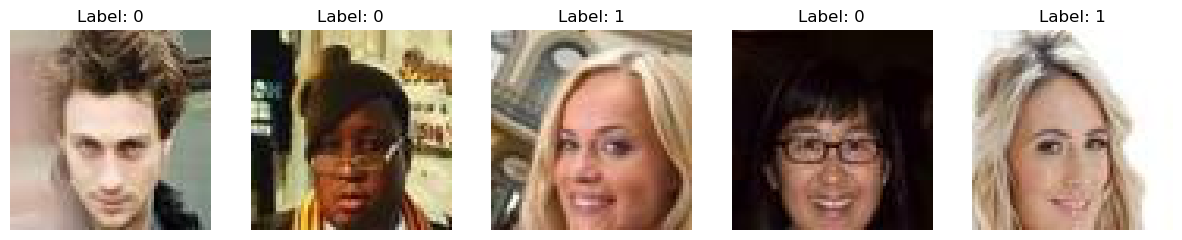

In [23]:
image_files = [f"{i+1:06d}.jpg" for i in range(len(labels))]
k = 480
sample_images = image_files[k:k+5]

plt.figure(figsize=(15, 10))
for i, img_name in enumerate(sample_images):
    img_path = os.path.join(original_folder, img_name)
    img = mpimg.imread(img_path)
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(f"Label: {labels[i+k]}")
    plt.axis('off')

plt.show()


### Visual analysis
Visually, it is challenging to discern the relationship between the labels and the images, yet.



In [ ]:
label_counts = Counter(labels)
print(f"labels counter: {label_counts}")

#### Dataset Imbalance
We are working with a binary dataset that is highly imbalanced, with the positive labels being seven times more frequent than the negative labels.

To properly evaluate the model, we will split the dataset into training and testing sets, ensuring that the test set is balanced (see `split_dataset` module). Additionally, during training, we will apply weighted sampling to account for the imbalance in the dataset.

In [24]:
# run this cell to split the original dataset into train/test dataset as described above.
!python split_dataset.py

100%|█████████████████████████████████| 100000/100000 [00:15<00:00, 6278.52it/s]


The folder structure is now this one   


In [25]:
#| dataset  
#|   |---- train 
#|           |---- 0
#|              |---- 0*****.jpg
#|              |---- 0*****.jpg
#|           |---- 1
#|              |---- 0*****.jpg
#|              |---- 0*****.jpg
#|   |---- test 
#|           |---- 0
#|              |---- 0*****.jpg
#|              |---- 0*****.jpg
#|           |---- 1
#|              |---- 0*****.jpg
#|              |---- 0*****.jpg

#### Dataloader
 We will use a dataset loader to load the dataset. During the training we will sample from the dataset while taking in account the imbalanceness if the data, we will also augment the data by mirroring and rotating within a fixed range the images. Further more we will be applying some blurring.

#### Model
We will use a state-of-the-art classifier model: ViT (Vision Transformer), a transformer-based architecture. We will initialize its weights using the publicly available pre-trained weights from Hugging Face and fine-tune the model using our training dataset.

The images will be resized to 224x224 to match the dimensions used in the original ViT training dataset.

In [1]:
#!train_model.py

In [2]:
!python best_model.py

Best model overall by accuracy: Step 215 with accuracy 0.903
Best model overall by F1-score: Step 215 with F1-score 0.9078822412155746
Best saved model by accuracy (every 25 steps): Step 175 with accuracy 0.882
Best saved model by F1-score (every 25 steps): Step 175 with F1-score 0.8923357664233577


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


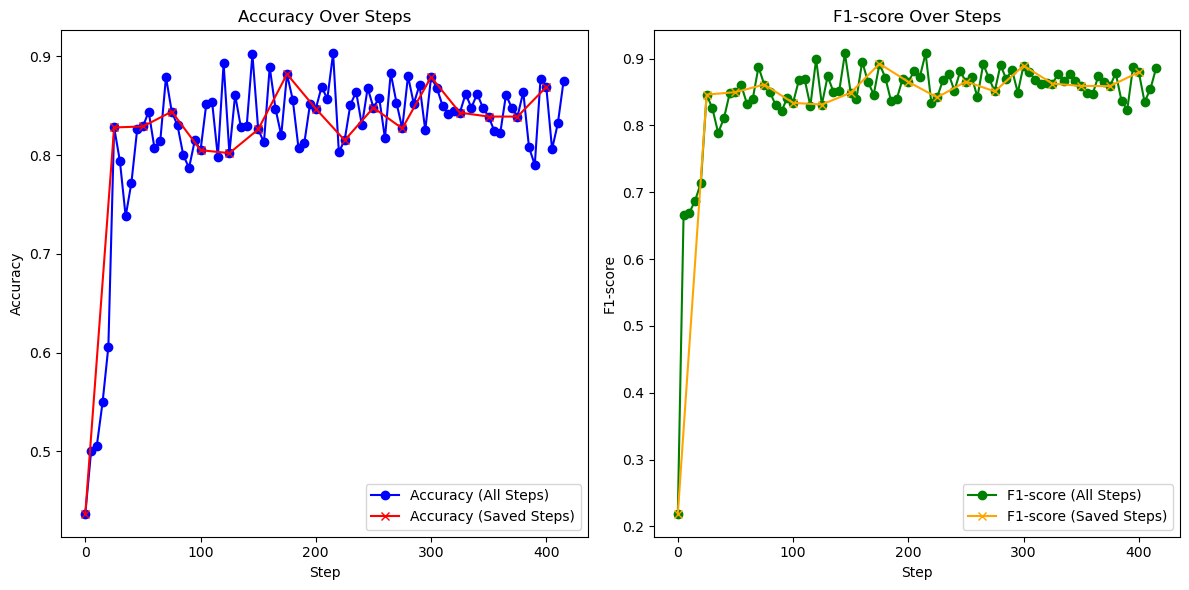

In [4]:
import re
import matplotlib.pyplot as plt

# Function to parse the log file and extract metrics for all steps and saved steps
def extract_metrics(file_path):
    # Lists to store metrics for all steps
    steps = []
    accuracies = []
    f1_scores = []

    # Lists to store metrics for saved steps (multiples of 25)
    saved_steps = []
    saved_accuracies = []
    saved_f1_scores = []

    # Regex pattern to match evaluation metrics
    pattern = r"eval_accuracy: ([\d\.]+), eval_loss: [\d\.]+, eval_precision: [\d\.]+, eval_recall: [\d\.]+, eval_f1: ([\d\.]+), eval_runtime: [\d\.]+, eval_samples_per_second: [\d\.]+, eval_steps_per_second: [\d\.]+, epoch: [\d\.]+, step: (\d+)"

    # Open and read the log file line by line
    with open(file_path, 'r') as file:
        for line in file:
            match = re.search(pattern, line)
            if match:
                eval_accuracy = float(match.group(1))
                eval_f1 = float(match.group(2))
                step = int(match.group(3))

                # Store metrics for all steps
                steps.append(step)
                accuracies.append(eval_accuracy)
                f1_scores.append(eval_f1)

                # Store metrics for saved steps (multiples of 25)
                if step % 25 == 0:
                    saved_steps.append(step)
                    saved_accuracies.append(eval_accuracy)
                    saved_f1_scores.append(eval_f1)

    return steps, accuracies, f1_scores, saved_steps, saved_accuracies, saved_f1_scores

# Function to plot the metrics
def plot_metrics(file_path):
    # Extract metrics from the log file
    steps, accuracies, f1_scores, saved_steps, saved_accuracies, saved_f1_scores = extract_metrics(file_path)

    # Create subplots
    plt.figure(figsize=(12, 6))

    # Plot accuracy over steps
    plt.subplot(1, 2, 1)
    plt.plot(steps, accuracies, label='Accuracy (All Steps)', color='blue', marker='o')
    plt.plot(saved_steps, saved_accuracies, label='Accuracy (Saved Steps)', color='red', marker='x')
    plt.xlabel('Step')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Steps')
    plt.legend()

    # Plot F1-score over steps
    plt.subplot(1, 2, 2)
    plt.plot(steps, f1_scores, label='F1-score (All Steps)', color='green', marker='o')
    plt.plot(saved_steps, saved_f1_scores, label='F1-score (Saved Steps)', color='orange', marker='x')
    plt.xlabel('Step')
    plt.ylabel('F1-score')
    plt.title('F1-score Over Steps')
    plt.legend()

    # Show the plots
    plt.tight_layout()
    plt.show()

# File path to the log file
log_file_path = './output_logs.txt'

# Call the function to plot the metrics
plot_metrics(log_file_path)